# playing Atari with Deep Learning

In [1]:
# choose game
game = "Pong-v0"

# generate Dataset by random play

* saving only good sequences

In [2]:
import numpy as np
import gym

env = gym.make(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 1500
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 100 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Dataset completed


# Preprocessing

In [3]:
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data.shape, y_data.shape

((116229, 210, 160, 3), (116229,))

In [4]:
x_data[0].shape

(210, 160, 3)

### resize images to 84x84 pixels

In [5]:
import cv2
def resize(img):
    height = 84
    width = 84
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

In [6]:
resized_x_data = [resize(img) for img in x_data]
resized_x_data = np.array(resized_x_data)

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)

axs[0].imshow(x_data[0, :, :, :])
axs[0].set_title("Original", fontsize="15")
axs[1].imshow(resized_x_data[0, :, :, :])
axs[1].set_title("Resized", fontsize="15")

Text(0.5, 1.0, 'Resized')

### RGB to Grayscale

In [8]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [9]:
gray_x_data = [grayscale(img) for img in resized_x_data]
gray_x_data = np.array(gray_x_data)

Text(0.5, 1.0, 'Grayscale')

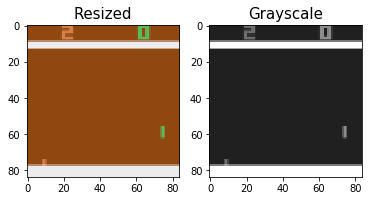

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(resized_x_data[0, :, :, :])
axs[0].set_title("Resized", fontsize="15")
axs[1].imshow(gray_x_data[0, :, :, 0], cmap="gray")
axs[1].set_title("Grayscale", fontsize="15")

### Frame Stack

In [11]:
from collections import deque
def framestack(dataset):
    data = []
    frames = deque(maxlen=4)

    # initialize first deque
    for _ in range(4):
        frames.append(dataset[0])
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)

    # create deques from dataset
    for state in dataset:
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)
        data.append(framestack)

    return data

In [12]:
stack_data = framestack(gray_x_data) 
stack_data = np.array(stack_data)

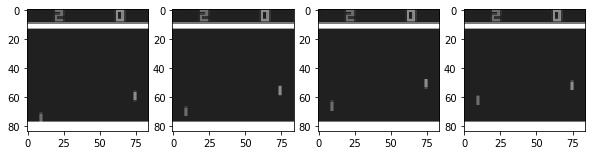

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
axs[0].imshow(stack_data[0+4, :, :, 0], cmap="gray") # +4, because of 4 same initial frames
axs[1].imshow(stack_data[1+4, :, :, 1], cmap="gray")
axs[2].imshow(stack_data[2+4, :, :, 2], cmap="gray")
axs[3].imshow(stack_data[3+4, :, :, 3], cmap="gray")

### converting labels to categorical labels

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y=y_data, num_classes=env.action_space.n)

### shuffle data

In [15]:
# create random indices
idx = np.random.permutation(len(x_data))
# x - resized grayscale input
# x_stacked - resized grayscale input in framestacks
# labels - actions in to_categorical
x, x_stacked, labels = gray_x_data[idx], stack_data[idx], y[idx]

# create a model


In [44]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def create_nn(input_shape, output_shape):
    net_input = Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    x = Dense(output_shape)(x)
    net_output = Activation("softmax")(x)

    OPTIMIZER = Adam(lr=0.00005)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["categorical_accuracy"])

    return model

# Train a model on resized-grayscale input



In [17]:
x.shape[1:]

(84, 84, 1)

In [18]:
labels.shape[1]

6

In [48]:
model_1 = create_nn(x.shape[1:], labels.shape[1])

In [49]:
EPOCHS = 250

result_1 = model_1.fit(
    x,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/250
116229/116229 [==============================] - 9s 80us/sample - loss: 1.9791 - categorical_accuracy: 0.1726
Epoch 2/250
116229/116229 [==============================] - 8s 71us/sample - loss: 1.8264 - categorical_accuracy: 0.1699
Epoch 3/250
116229/116229 [==============================] - 9s 76us/sample - loss: 1.8061 - categorical_accuracy: 0.1747
Epoch 4/250
116229/116229 [==============================] - 8s 71us/sample - loss: 1.7996 - categorical_accuracy: 0.1743
Epoch 5/250
116229/116229 [==============================] - 8s 72us/sample - loss: 1.7947 - categorical_accuracy: 0.1783
Epoch 6/250
116229/116229 [==============================] - 9s 74us/sample - loss: 1.7917 - categorical_accuracy: 0.1812
Epoch 7/250
116229/116229 [==============================] - 8s 71us/sample - loss: 1.7906 - categorical_accuracy: 0.1810
Epoch 8/250
116229/116229 [==============================] - 8s 73us/sample - loss: 1.7893 - categorical_accuracy: 0.1819
Epoch 9/250
116229/11622

116229/116229 [==============================] - 9s 74us/sample - loss: 0.8695 - categorical_accuracy: 0.6758
Epoch 68/250
116229/116229 [==============================] - 8s 70us/sample - loss: 0.8551 - categorical_accuracy: 0.6806
Epoch 69/250
116229/116229 [==============================] - 8s 71us/sample - loss: 0.8437 - categorical_accuracy: 0.6850
Epoch 70/250
116229/116229 [==============================] - 9s 74us/sample - loss: 0.8335 - categorical_accuracy: 0.6880
Epoch 71/250
116229/116229 [==============================] - 8s 71us/sample - loss: 0.8176 - categorical_accuracy: 0.6950
Epoch 72/250
116229/116229 [==============================] - 8s 69us/sample - loss: 0.8079 - categorical_accuracy: 0.6973
Epoch 73/250
116229/116229 [==============================] - 9s 77us/sample - loss: 0.7979 - categorical_accuracy: 0.7024
Epoch 74/250
116229/116229 [==============================] - 8s 70us/sample - loss: 0.7848 - categorical_accuracy: 0.7067
Epoch 75/250
116229/116229 [=

116229/116229 [==============================] - 8s 70us/sample - loss: 0.4824 - categorical_accuracy: 0.8197
Epoch 134/250
116229/116229 [==============================] - 9s 77us/sample - loss: 0.4798 - categorical_accuracy: 0.8208
Epoch 135/250
116229/116229 [==============================] - 8s 71us/sample - loss: 0.4733 - categorical_accuracy: 0.8233
Epoch 136/250
116229/116229 [==============================] - 8s 70us/sample - loss: 0.4728 - categorical_accuracy: 0.8214
Epoch 137/250
116229/116229 [==============================] - 9s 77us/sample - loss: 0.4709 - categorical_accuracy: 0.8229
Epoch 138/250
116229/116229 [==============================] - 8s 72us/sample - loss: 0.4688 - categorical_accuracy: 0.8247
Epoch 139/250
116229/116229 [==============================] - 8s 69us/sample - loss: 0.4670 - categorical_accuracy: 0.8242
Epoch 140/250
116229/116229 [==============================] - 9s 75us/sample - loss: 0.4644 - categorical_accuracy: 0.8265
Epoch 141/250
116229/1

116229/116229 [==============================] - 8s 72us/sample - loss: 0.3856 - categorical_accuracy: 0.8551
Epoch 200/250
116229/116229 [==============================] - 8s 71us/sample - loss: 0.3834 - categorical_accuracy: 0.8566
Epoch 201/250
116229/116229 [==============================] - 9s 74us/sample - loss: 0.3837 - categorical_accuracy: 0.8565
Epoch 202/250
116229/116229 [==============================] - 9s 73us/sample - loss: 0.3797 - categorical_accuracy: 0.8572
Epoch 203/250
116229/116229 [==============================] - 8s 70us/sample - loss: 0.3829 - categorical_accuracy: 0.8566
Epoch 204/250
116229/116229 [==============================] - 9s 73us/sample - loss: 0.3785 - categorical_accuracy: 0.8588
Epoch 205/250
116229/116229 [==============================] - 9s 74us/sample - loss: 0.3791 - categorical_accuracy: 0.8580
Epoch 206/250
116229/116229 [==============================] - 8s 71us/sample - loss: 0.3776 - categorical_accuracy: 0.8587
Epoch 207/250
116229/1

In [50]:
model_1.save_weights("model_1.h5")

In [56]:
for episode in range(5):
    done = False
    episode_reward = 0.0
    state = env.reset()
    state = resize(state)
    state = grayscale(state)
    state = np.reshape(state, (1, 84, 84, 1))
    state = state.astype("float32")
    while not done:
        action = np.argmax(model_1.predict(state))
        state, reward, done, info = env.step(action)
        state = resize(state)
        state = grayscale(state)
        state = np.reshape(state, (1, 84, 84, 1))
        state = state.astype("float32")
        episode_reward += reward
    print("Episode:", episode+1, "\tReward:", episode_reward)

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7ef6045d4198>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 541, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1175, in delete_iterator
    "DeleteIterator", handle=handle, deleter=deleter, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
    inp = self.capture(inp)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/func_graph.py", line 594, in capture
    name = tensor.op.name
  File 

Episode: 1 	Reward: -15.0
Episode: 2 	Reward: -18.0
Episode: 3 	Reward: -16.0
Episode: 4 	Reward: -19.0
Episode: 5 	Reward: -17.0


# Train a model on resized-grayscale-framestack input



In [21]:
x_stacked.shape[1:]

(84, 84, 4)

In [22]:
labels.shape[1]

6

In [29]:
model_2 = create_nn(x_stacked.shape[1:], labels.shape[1])

In [30]:
EPOCHS = 250

result_2 = model_2.fit(
    x_stacked,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30
116229/116229 [==============================] - 53s 455us/sample - loss: 1.9934 - categorical_accuracy: 0.1681
Epoch 2/30
116229/116229 [==============================] - 52s 450us/sample - loss: 1.9052 - categorical_accuracy: 0.1704
Epoch 3/30
110624/116229 [===========================>..] - ETA: 2s - loss: 1.8797 - categorical_accuracy: 0.1712

KeyboardInterrupt: 